# Practical 4

In [1]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd gdrive/MyDrive/ml_2021

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ml_2021


## Task 0: The Data

We will work with the data from practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [3]:
# Split data in training and test set
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    shuffle_ids = np.array(range(len(y)))
    np.random.shuffle(shuffle_ids)

    slice_ind = int((1-frac) * len(y))

    X = pd.DataFrame(X)

    X = pd.DataFrame.reset_index((X.loc[shuffle_ids,:]), 
                                 drop = True)
    y = y[shuffle_ids]

    X_train = X.loc[:slice_ind-1,]
    y_train = y[:slice_ind]

    X_test = X.loc[slice_ind:,]
    y_test = y[slice_ind:]


    return np.array(X_train), np.array(X_test), y_train, y_test

In [4]:
# load data
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:,:2], np.load('data/nonlin_2d_data.npy')[:, 2]

In [5]:
# split data
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)

## Task 1: Support Vector Machines

First, you will implement a training algorithm for the Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters.

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.

In [7]:
def rbf_kernel(x_n, x_m, gamma=1/5):
    tmp = np.square(x_n - x_m)
    tmp = -(1/gamma) * np.sum(tmp)
    return np.exp(tmp)

In [8]:
def accuracy(y_true, y_pred):
  n_c = np.sum((y_true == y_pred)) #number of correctly classified
  acc = n_c/len(y_true)
  return acc

In [9]:
def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.'''

    t = np.array([-1 if l == 0 else 1 for l in t])
    
    tmat = np.diag(t)
    Ptmp = np.array([kernel(xn,xm) for xn in X for xm in X]).reshape((len(X), len(X)))
    P = np.matmul(np.matmul(tmat, Ptmp), tmat)

    q = -1 * np.ones(len(X))
    A = np.array([float(k) for k in t]).reshape((1,len(X)))
    b = np.array([0.]).reshape((1,1))

    onev = np.array([-1, 1])
    G = np.kron(np.identity(len(X)), onev.reshape((2,1)))
    tmp = np.array([0,C])
    h = np.tile(tmp, len(X))
    
    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, len(X)) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * len(X)
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult, C, threshold=1e-5):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        threshold: threshold for choosing support vectors
    
    Returns
        lagr_mult: lagrange multipliers for the support vectors
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept
    '''
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    # ---------------- INSERT CODE ----------------------

    sv_inds = (lagr_mult > threshold) & (lagr_mult < (C-threshold))
    svs, sv_labels, lagr_mult = X[sv_inds], t[sv_inds], lagr_mult[sv_inds]

    mlen = len(svs)

    intercept = 0
    for i in range(mlen):
      tmp = np.array([lagr_mult[m] * sv_labels[m] * kernel(svs[i], svs[m]) for m in range(mlen)]).sum()
      intercept += (1/mlen) * (sv_labels[i] - tmp)

    # ---------------- END CODE -------------------------

    return lagr_mult, svs, sv_labels, intercept


In [10]:
# Fit SVM on training data
sols = fit_svm(X_train, t_train, rbf_kernel)

# Extract parameters
lagr, svs, sv_labels, intercept = extract_parameters(X_train, t_train, rbf_kernel, sols, 1.0)

     pcost       dcost       gap    pres   dres
 0: -1.2697e+01 -2.3383e+02  2e+02  1e-14  4e-16
 1: -1.5283e+01 -2.8473e+01  1e+01  2e-16  4e-16
 2: -1.6134e+01 -1.8688e+01  3e+00  7e-16  2e-16
 3: -1.6460e+01 -1.7038e+01  6e-01  3e-16  2e-16
 4: -1.6569e+01 -1.6692e+01  1e-01  2e-16  2e-16
 5: -1.6589e+01 -1.6645e+01  6e-02  8e-16  2e-16
 6: -1.6601e+01 -1.6608e+01  7e-03  1e-15  2e-16
 7: -1.6603e+01 -1.6603e+01  3e-04  6e-16  2e-16
 8: -1.6603e+01 -1.6603e+01  6e-06  2e-16  2e-16
Optimal solution found.


### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with your Gaussian RBF kernel (Practical 3) and compute the test accuracy on the 2d dataset.

In [11]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept):
    
    # ---------------- INSERT CODE ----------------------
    mlen = len(lagr_mult)

    prediction = []
    for x in X:
      tmp = np.array([lagr_mult[m] * sv_labels[m] * kernel(svs[m], x) for m in range(mlen)]).sum()
      pred = int((intercept + tmp)>0)
      prediction.append(pred)


    # ---------------- END CODE -------------------------
    
    return np.array(prediction)

In [22]:
# Calculate test accuracy
y_train = svm_predict(X_train, rbf_kernel, lagr, svs, sv_labels, intercept)
y_test = svm_predict(X_test, rbf_kernel, lagr, svs, sv_labels, intercept)
print("The accuracy on the training set is", accuracy(t_train, y_train), "and on the test set", accuracy(t_test, y_test))

The accuracy on the training set is 0.9771428571428571 and on the test set 0.9866666666666667


### Task 1.3

- Instead of using the Gaussian RBF kernel, use the linear kernel (dot product) defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels.

In [13]:
def linear_kernel(x_n, x_m):
    return np.matmul(x_n.T, x_m)

In [14]:
# Fit SVM with linear kernel and calculate the test accuracy
# Fit SVM on training data
sols_lk = fit_svm(X_train, t_train, linear_kernel)

# Extract parameters
lagr_lk, svs_lk, sv_labels_lk, intercept_lk = extract_parameters(X_train, t_train, linear_kernel, sols_lk, 1.0)

     pcost       dcost       gap    pres   dres
 0: -1.6611e+02 -3.8981e+02  1e+03  2e+00  3e-14
 1: -1.2559e+02 -2.6081e+02  1e+02  8e-15  2e-14
 2: -1.3748e+02 -1.5048e+02  1e+01  3e-16  1e-14
 3: -1.3799e+02 -1.3813e+02  1e-01  4e-15  1e-14
 4: -1.3800e+02 -1.3800e+02  1e-03  4e-15  1e-14
 5: -1.3800e+02 -1.3800e+02  1e-05  8e-15  1e-14
Optimal solution found.


In [23]:
y_train_lk = svm_predict(X_train, linear_kernel, lagr_lk, svs_lk, sv_labels_lk, intercept_lk)
y_test_lk = svm_predict(X_test, linear_kernel, lagr_lk, svs_lk, sv_labels_lk, intercept_lk)
print("The accuracy on the training set is", accuracy(t_train, y_train_lk), "and on the test set", accuracy(t_test, y_test_lk))

The accuracy on the training set is 0.4342857142857143 and on the test set 0.52


In [16]:
# Fit SVM using sklearn and calculate the test accuracy
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, t_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [24]:
y_train_sk = clf.predict(X_train)
y_test_sk = clf.predict(X_test)
print("The accuracy on the training set is", accuracy(t_train, y_train_sk), "and on the test set", accuracy(t_test, y_test_sk))

The accuracy on the training set is 0.9942857142857143 and on the test set 1.0


In [18]:
def plt2d(data, labels, title):
  plt.scatter(data[:,0], data[:,1], c = labels)
  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')
  plt.axis('square')   
  plt.title(title)

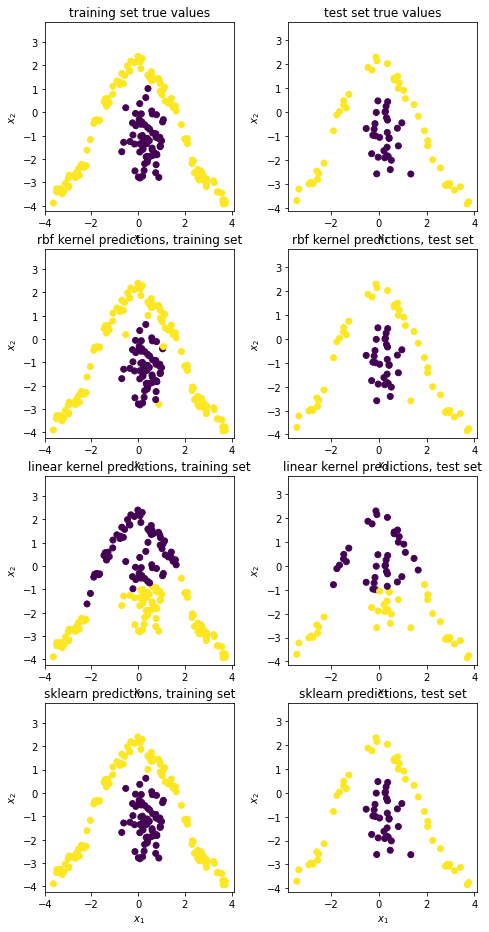

In [26]:
# Visualize
# Visualize results
plt.figure(figsize=(8,16))

plt.subplot(4,2,1)
plt2d(X_train, t_train, title = 'training set true values')

plt.subplot(4,2,2)
plt2d(X_test, t_test, title = 'test set true values')

plt.subplot(4,2,3)
plt2d(X_train, y_train, title = 'rbf kernel predictions, training set')

plt.subplot(4,2,4)
plt2d(X_test, y_test, title = 'rbf kernel predictions, test set')

plt.subplot(4,2,5)
plt2d(X_train, y_train_lk, title = 'linear kernel predictions, training set')

plt.subplot(4,2,6)
plt2d(X_test, y_test_lk, title = 'linear kernel predictions, test set')

plt.subplot(4,2,7)
plt2d(X_train, y_train_sk, title = 'sklearn predictions, training set')

plt.subplot(4,2,8)
plt2d(X_test, y_test_sk, title = 'sklearn predictions, test set')

plt.show() 

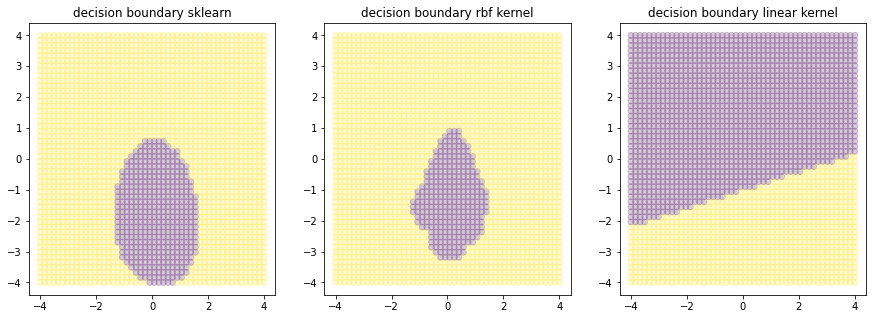

In [20]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()

    grid_t = np.zeros(len(grid_x))
    for i, p in enumerate(zip(grid_x, grid_y)):
      tmp = np.array(p)
      tmp = np.reshape(tmp, (1, 2))
      grid_t[i] = predict_fn(tmp)

    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
predict_fn = lambda x: clf.predict(x)
plot_decision_boundary(predict_fn)
plt.title('decision boundary sklearn')

plt.subplot(1, 3, 2)
predict_fn = lambda x: svm_predict(x, rbf_kernel, lagr, svs, sv_labels, intercept)
plot_decision_boundary(predict_fn)
plt.title('decision boundary rbf kernel')

plt.subplot(1, 3, 3)
predict_fn = lambda x: svm_predict(x, linear_kernel, lagr_lk, svs_lk, sv_labels_lk, intercept_lk)
plot_decision_boundary(predict_fn)
plt.title('decision boundary linear kernel')
plt.show()

# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [ ]:
# Load Wine dataset and split into train+test set

X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

In [ ]:
# Plot distribution


In [ ]:
# Compute Gini impurity


### Task 2.2
Split the data along the first 12 features and plot the removed Gini impurity at different values of this feature. Which is the optimal split?

In [ ]:
# Plotting


### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [ ]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label


In [ ]:
# Implement recursive tree function

def build_tree(X, t, depth, max_depth=3, n_labels=2):
    
    # ---------------- INSERT CODE ----------------------



    # ---------------- END CODE -------------------------

    
def predict_tree(node, x):
    
    # ---------------- INSERT CODE ----------------------



    # ---------------- END CODE -------------------------

In [ ]:
# Build tree

tree = build_tree(X_train, t_train, 0, max_depth=3, n_labels=3)

In [ ]:
# Calculate training and test scores


In [ ]:
# Calculate test score using sklearn


In [ ]:
# Calculate test score for synthetic 2D dataset


In [ ]:
# Visualize
